#**Detecting Fake Reviews**

Fake review detection is an older topic in Computer Science: https://aclanthology.org/N13-1053.pdf. There even used to be a consumer-facing tool based on the model, here: https://web.archive.org/web/20220705181250/http://reviewskeptic.com/.

In [1]:
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import io

uploaded = files.upload()
reviews = pd.read_csv(io.BytesIO(uploaded['fake reviews dataset.csv']))

reviews.describe(include='all')

Saving fake reviews dataset.csv to fake reviews dataset.csv


,category,rating,label,text_
count,40432,40432.000000,40432,40432
unique,10,NaN,2,40412
top,Kindle_Store_5,NaN,CG,My dog loves these and it has kept her occupie...
freq,4730,NaN,20216,2
mean,NaN,4.256579,NaN,NaN
std,NaN,1.144354,NaN,NaN
min,NaN,1.000000,NaN,NaN
25%,NaN,4.000000,NaN,NaN
50%,NaN,5.000000,NaN,NaN
75%,NaN,5.000000,NaN,NaN


Let's see if there is likely signal in the text to predict review authenticity?

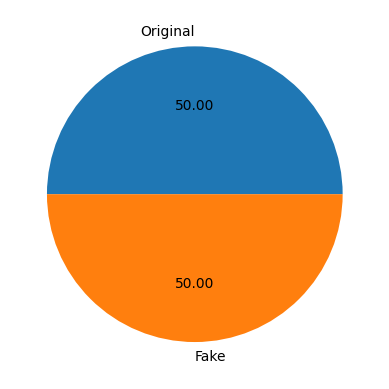

In [2]:
plt.pie(reviews['label'].value_counts(), labels=['Original', 'Fake'], autopct="%0.2f")
plt.show()

And let's look at characer, word, and sentence counts...

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


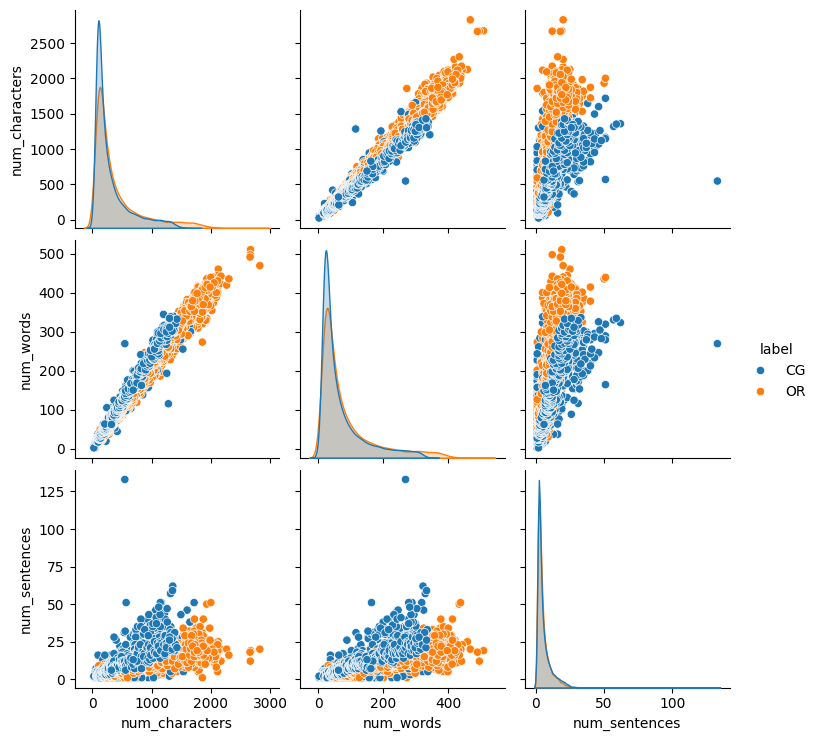

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

reviews['num_characters'] = reviews['text_'].apply(len)
reviews['num_words'] = reviews['text_'].apply(lambda x:len(nltk.word_tokenize(x)))
reviews['num_sentences'] = reviews['text_'].apply(lambda x:len(nltk.sent_tokenize(x)))

sns.pairplot(reviews[['num_characters','num_words','num_sentences','label']],hue='label')

We can use some of the Keras utilities to pre-process the text.

*Q: What features should we use for our prediction?*

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.text import text_to_word_sequence

text = []
for i in range(len(reviews)):
  text.append(text_to_word_sequence(reviews['text_'][i])) # This strips punctuation, odd characters, and makes things lower-case.

This is another pre-processing step, but it's optional.

*Q: What does this code block do?*

In [ ]:
min_freq = 1

word_freq = {}
for review in text:
  for word in review:
    try:
        word_freq[word] = word_freq[word]+1
    except KeyError:
        word_freq[word] = 1

max_freq = max(i for i in word_freq.values())
for i in range(len(text)):
  text[i] = [word for word in text[i] if word_freq[word] >= min_freq & word_freq[word] <= max_freq]

Here, we are making our integer codings for the text tokens.

In [5]:
# We declare a set, which we populate from terms from the corpus, one by one.
# Sets only allow 'unique' values.
unique_terms = {word for review in text for word in review}
print(f'We have {len(unique_terms)} unique tokens in our dataset.')

# We can then easily make a term-integer dictionary and an integer-term dictionary (for reverse lookup)
word_index = {word: number for number, word in enumerate(unique_terms)}
reverse_index = {number: word for number, word in enumerate(unique_terms)}

We have 43596 unique tokens in our dataset.


One-hot encoding the text can be done very explicitly now, as a nested loop.

In [6]:
def vectorize_sequences(sequences, dimension=len(unique_terms)):
    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(sequences), dimension))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, word_index[j]] = 1.
    return results

text_onehot = vectorize_sequences(text)

text_onehot.shape

(40432, 43596)

Don't forget we have another feature in the data. It's not just about the review text...

In [7]:
# One hot encoding the hotels.
category_dict = {category : index for index, category in enumerate(set(reviews['category']))}
categories = []
for category in reviews['category']:
  categories.append(category_dict[category])

categories_onehot = keras.utils.to_categorical(np.array(categories))

# Reshape the rating series to have two dimensions
ratings_reshaped = reviews['rating'].values.reshape(-1, 1)

predictors = np.concatenate((text_onehot,categories_onehot,ratings_reshaped),axis=1)
labels = np.where(reviews['label']=='CG',0,1)


What does our final set of predictors look like?

In [ ]:
display(predictors[:5])
display(labels[:5])

array([[0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 5.]])

array([0, 0, 0, 0, 0])

Now we can fit out model to the resulting data. We will set shuffle = True to randomly shuffle the data (why?). We will also set a validation split of 0.20.

In [8]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import numpy as np

model = keras.Sequential([
    #layers.BatchNormalization(),
    #layers.Dropout(0.4),
    # We are reducing the one-hot encoded text (40,000+ one-hot tokens) down to 750 latent dimensions.
    layers.Dense(750, activation="relu",kernel_regularizer="l2"),
    layers.Dense(50, activation="relu",kernel_regularizer="l2"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["binary_accuracy"])

history = model.fit(predictors, labels,
                        validation_split=0.2,
                        epochs=20,
                    shuffle=True,
                    batch_size=16)

Epoch 1/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - binary_accuracy: 0.7614 - loss: 13.5563 - val_binary_accuracy: 0.8188 - val_loss: 7.4167
Epoch 2/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - binary_accuracy: 0.8670 - loss: 6.1588 - val_binary_accuracy: 0.8432 - val_loss: 3.5234
Epoch 3/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - binary_accuracy: 0.8780 - loss: 2.9294 - val_binary_accuracy: 0.8425 - val_loss: 1.7994
Epoch 4/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - binary_accuracy: 0.8814 - loss: 1.4952 - val_binary_accuracy: 0.8190 - val_loss: 1.0712
Epoch 5/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - binary_accuracy: 0.8875 - loss: 0.8504 - val_binary_accuracy: 0.8405 - val_loss: 0.6916
Epoch 6/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - binary_accuracy: 0.8864 - loss: 0.5633 - val_binary_accuracy: 0.8504 - val_loss: 0.5229
Epoch 7/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - binary_accuracy: 0.8905 - loss: 0.4307 - val_binary_accuracy: 0.8482 - val_los

Here we plot the performance during training:

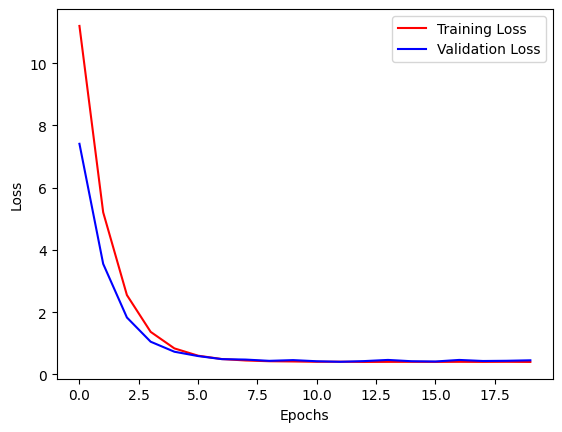

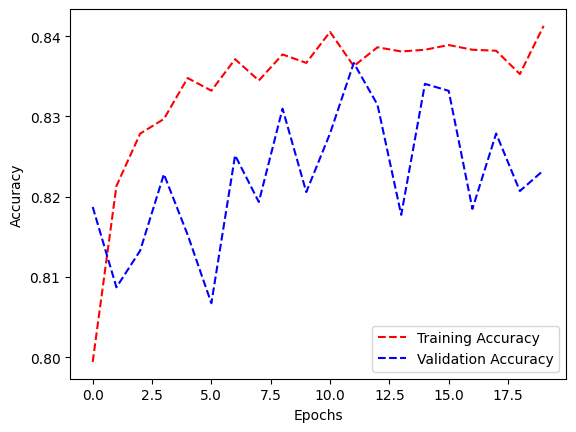

In [ ]:
train_loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
train_acc_history = history.history['binary_accuracy']
val_acc_history = history.history['val_binary_accuracy']

# Plot validation performance.
plt.plot(train_loss_history,c='r')
plt.plot(val_loss_history,c='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Validation Loss'])
plt.show()

plt.plot(train_acc_history,c="r",linestyle="dashed")
plt.plot(val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy','Validation Accuracy'])

Overall accuracy of the final model?

In [ ]:
evaluation = model.evaluate(predictors,labels)

print(f'Loss: {evaluation[0]}')
print(f'Accuracy: {evaluation[1]}')

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - binary_accuracy: 0.8864 - loss: 0.2947
Loss: 0.30022987723350525
Accuracy: 0.8880094885826111


And let's produce a confusion matrix...

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Get predictions for the entire dataset
predictions = model.predict(predictors)

# Apply a threshold of 0.5 to get binary predictions
binary_predictions = (predictions >= 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, binary_predictions)

# You can also display it as a pandas DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("\nConfusion Matrix (DataFrame):")
display(conf_matrix_df)

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Confusion Matrix:
[[19629   587]
 [ 3941 16275]]

Confusion Matrix (DataFrame):


,Predicted 0,Predicted 1
Actual 0,19629,587
Actual 1,3941,16275


How might I then use this trained model to label a new review?

In [ ]:
first_review = predictors[0].reshape(1,predictors.shape[1])

print(reviews.loc[0,'text_'])
print(reviews.loc[0,'rating'])
print(reviews.loc[0,'category'])
print(reviews.loc[0,'label'])

prediction = model.predict(first_review)
print(f'Fake? {prediction >= 0.5}')



Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty
5.0
Home_and_Kitchen_5
CG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Fake? [[False]]
